# **PRACTICA FINAL FLUJOS DE DATOS**

**Ignacio Areal Antolín**

**Fernando Francisco Moya Rangel**

# Introducción

El aprendizaje incremental en flujos de datos busca modelos que aprendan de ejemplos que llegan secuencialmente, sin necesidad de almacenarlos todos en memoria, de modo que sean capaces de adaptarse a cambios en los datos sin olvidar conocimiento previo y nos permitan dar predicciones en tiempo real. Este  tipo de aprendizaje está ganando popularidad en los últimos años porque muchas aplicaciones reales (IoT, telemetría, monitoring, sistemas de recomendación) exigen adaptación continua al momento.

En esta práctica trabajaremos con distintas fuentes de datos de carácter socioeconómico, principalmente relacionados con el empleo, los salarios y el mercado inmobiliario. Aunque los conjuntos utilizados provienen de archivos CSV estáticos, puede imaginarse fácilmente un escenario real en el que estos datos lleguen de manera continua en forma de flujo. Por ejemplo, los registros de empleo y salarios podrían obtenerse en tiempo real a partir de una API que recoja ofertas publicadas en portales como Indeed o InfoJobs, mientras que los valores de viviendas podrían provenir de servicios de inmobiliarias que actualizan sus precios constantemente. De este modo, el uso de clasificadores y modelos incrementales sobre los datos simulados nos permite aproximarnos a un contexto más realista, donde las decisiones deben adaptarse dinámicamente a información que evoluciona con el tiempo.

# Estado del arte

El aprendizaje incremental en flujos de datos constituye un paradigma cuyo objetivo es permitir que los modelos se actualicen de forma continua a medida que los datos llegan secuencialmente, sin requerir un reentrenamiento completo ni acceso permanente a todo el conjunto histórico. Este enfoque es especialmente relevante en escenarios donde la distribución de los datos respecto al objetivo puede variar en el tiempo: concept drift (Gama et al., 2014). En este contexto, los métodos clásicos de data stream mining, como los árboles de Hoeffding (Domingos & Hulten, 2000), los ensambles adaptativos (Bifet et al., 2010) y los detectores estadísticos de cambio como DDM (Gama et al., 2004) o ADWIN (Bifet & Gavaldà, 2007), han demostrado ser efectivos para la actualización incremental.

En los últimos años, el campo ha evolucionado hacia el aprendizaje incremental con las arquitecturas del aprendizaje profundo continuo, con el fin de mitigar el olvido catastrófico inherente a las redes neuronales (Kirkpatrick et al., 2017). Las estrategias actuales se agrupan principalmente en tres categorías: regularización de parámetros (p. ej., Elastic Weight Consolidation, Learning without Forgetting), reutilización o replay de ejemplos pasados (Rebuffi et al., 2017; Rolnick et al., 2019) y reproducción generativa mediante modelos como VAE o GAN (Shin et al., 2017). Estas técnicas buscan preservar el conocimiento adquirido frente a nuevos patrones sin sacrificar la capacidad del modelo de aprender nuevos datos. Asimismo, la disponibilidad de frameworks especializados como River (Montiel et al., 2021) y Avalanche (Lomonaco et al., 2021) ha mejorado la evaluación estandarizada mediante protocolos prequential en entornos de flujos de datos.

Las líneas de investigación más recientes exploran la combinación entre detección de drift y estrategias de aprendizaje continuo profundo (Gunasekara et al., 2023) y el aprendizaje incremental federado y distribuido en entornos no estacionarios (Yoon et al., 2023).

En el ámbito de las ciencias socioeconómicas, el uso de aprendizaje incremental ha comenzado a cobrar relevancia en tareas que requieren la actualización constante de modelos ante la llegada de nuevos datos. Diversos trabajos recientes aplican técnicas de online learning para analizar la dinámica del empleo, los salarios y los mercados inmobiliarios, donde la información se genera de forma continua a través de portales de empleo, registros administrativos o servicios de intermediación digital. Por ejemplo, Qin et al. (2025, COTR: Efficient Job Task Recognition for Occupational Information Systems with Class-Incremental Learning) emplean un enfoque de aprendizaje incremental por clases combinado con LLMs para la identificación automática de tareas laborales a partir de descripciones de ofertas de empleo. De manera similar, otros estudios en economía computacional han explorado el uso de modelos incrementales y detección de concept drift para anticipar fluctuaciones en la demanda laboral, monitorizar tendencias salariales regionales o estimar en tiempo real variaciones en los precios de vivienda (Bifet et al. River: machine learning for streaming data in Python). Estas investigaciones ponen de manifiesto el potencial del aprendizaje incremental como herramienta para capturar la naturaleza dinámica de los fenómenos socioeconómicos y apoyar la toma de decisiones basada en datos en entornos cambiantes.

In [1]:
!pip install river

# Imports

In [1]:
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import os
from river import feature_selection
from river import preprocessing, cluster, stream, evaluate, metrics, compose, tree, datasets, drift, naive_bayes, ensemble
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import random
from river import forest
from river import ensemble
from river import linear_model
from river import feature_selection
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.datasets import fetch_california_housing
from river.feature_extraction import TFIDF 
from river.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans 
from sklearn.cluster import KMeans as SKKMeans



In [235]:
random.seed(42)

# 1.Clasificación
Para nuestro problema de clasificación hemos escogido el conjunto de datos Adult del UCI Machine Learning Repository, el cual recoge información demográfica y laboral de personas (edad, nivel educativo, tipo de empleo, horas de trabajo, etc.) junto con una etiqueta binaria que indica si sus ingresos anuales superan los 50 000 USD.


# Objetivo
Aunque se trata de un dataset estático, presenta varias características que lo hacen ideal para simular un flujo de datos:

Naturaleza temporal implícita: los registros reflejan una realidad socioeconómica que, en la práctica, puede evolucionar a lo largo del tiempo.

Tamaño moderado pero suficiente: permite iterar muchas instancias de forma eficiente, como si fueran llegadas sucesivas de información de nuevos individuos.

Problema de clasificación binaria realista: predecir si una persona supera un umbral de ingresos es un caso de uso frecuente en sistemas de recomendación de créditos, análisis de riesgo o planificación social.

El objetivo de esta parte de nuestro trabajo consiste en replicar condiciones cercanas a un sistema en producción que recibe datos demográficos en tiempo real, facilitando la transición a un entorno real de big data.

### 1.1 Carga del csv y vista preliminar

In [236]:
csv_file = "data/adult.csv"

# Carga inicial solo para inspección
df = pd.read_csv(csv_file)
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


### 1.2 Simular flujo de datos:

Transformamos el CSV en un generador que emite cada fila como un registro de flujo.
La columna `income` se convierte a binaria (1 si >50K, 0 en caso contrario).

In [237]:
data_stream = stream.iter_csv(
    csv_file,
    target="income",
    converters={
        "income": lambda x: 1 if ">50K" in str(x) else 0
    }
)

# Desarrollo

### 1.3 Función para elegir el modelo

In [238]:
def elegir_modelo(nombre_modelo: str):
    nombre = nombre_modelo.lower()
    if nombre == "hdt":
        return tree.HoeffdingTreeClassifier()
    elif nombre == "hat":
        return tree.HoeffdingAdaptiveTreeClassifier() # rolling para ver el accuracy en las últimas n instancias
    elif nombre == "efdt":
        return tree.ExtremelyFastDecisionTreeClassifier()
    else:
        raise ValueError("Modelo no reconocido. Usa: 'HDT', 'HAT' o 'EFDT'.")

### 1.4 Función para elegir el detector de drift

In [239]:
def elegir_detector(nombre: str):
    if nombre == "DDM":
        return drift.binary.DDM()
    elif nombre == "ADWIN":
        return drift.ADWIN()
    elif nombre == "HDDM_W":
        return drift.binary.HDDM_W()
    elif nombre == "HDDM_A":
        return drift.binary.HDDM_A()
    elif nombre == "KSWIN":
        return drift.KSWIN(alpha=0.01, window_size=200, stat_size=50) #AJUSTABLE
    elif nombre =="PH":
       return drift.PageHinkley()
    else:
        raise ValueError(
            "Detector no reconocido. Usa: 'DDM', 'ADWIN', 'HDDM_W', 'KSWIN' o 'PH'."
        )


### 1.5 Evaluación con evaluación progresiva

`evaluate.progressive_val_score` realiza el ciclo test-then-train automáticamente:
1. Predice la instancia entrante.
2. Actualiza la métrica.
3. Entrena el modelo.

In [240]:
def evaluar_modelo(data, modelo_nombre):
    modelo = elegir_modelo(modelo_nombre)
    metricas = metrics.Accuracy()
    print(f"*** Evaluación con modelo: {modelo_nombre.upper()} ***\n")
    resultado = evaluate.progressive_val_score(
        dataset=data,
        model=modelo,
        metric=metricas,
        print_every=1000  # imprime cada 1000 instancias
    )
    print(f"Accuracy final: {resultado.get():.4f}")
    return resultado.get()

### 1.6 Evaluación con detección de drift

Cuando se detecta un drift, el modelo entrenado con datos anteriores deja de representar la realidad actual, por lo que en el código reinicia el modelo cada vez que detecta un concept drift. Es cierto que, justo después de reiniciarlo, el modelo tiene pocos ejemplos y su rendimiento baja. Pero este tiempo de bajo rendimiento es preferible a mantener un modelo que predice sistemáticamente mal debido a un cambio de distribución y en el contexto de nuestro sistema no necesitamos tener un modelo preparado en todo momento, sino que es preferible asegurarnos un mejor modelo a la larga. Más adelante, con el uso de ensembles este problema se solucionaría.

In [241]:
def evaluar_modelo_con_drift(data_stream, modelo_nombre, detector_nombre, delay):

    modelo = elegir_modelo(modelo_nombre)
    detector = elegir_detector(detector_nombre)

    acc = metrics.Accuracy()

    print(f"*** Evaluación con modelo {modelo_nombre.upper()} "
          f"y detector {detector_nombre.upper()} ***\n")

    for i, (X, y) in enumerate(data_stream, start=1):
        
        y_pred = modelo.predict_one(X)
        
        acc.update(y, y_pred)

        # Actualizar detector con error (1 si fallo, 0 si acierto)
        detector.update(int(y_pred != y))

        if detector.drift_detected:
            print(f"[Drift detectado en instancia {i}] "
                    f"Accuracy acumulada antes de reinicio: {acc.get():.4f}")
            # Reiniciar modelo y detector
            modelo = elegir_modelo(modelo_nombre)
            detector = elegir_detector(detector_nombre)

        modelo.learn_one(X, y)

        if i % 1000 == 0:
            print(f"Instancia {i} | Accuracy: {acc.get():.4f}")

        if delay > 0:
            time.sleep(delay)

    print(f"\nAccuracy final: {acc.get():.4f}")
    return acc.get()


### 1.7 Evaluación con HDT

Probaremos con HDT, ya que realmente no deberíamos detectar demasiados drifts, ya que los datos no deberían cambiar su distribución con el tiempo de manera significativo. En caso de encontrar muchos concept drifts, podríamos usar modelos que tengan métodos para manejarlos como HDAT o EFDT.

In [10]:
data_stream = stream.iter_csv(
    csv_file,
    target="income",
    converters={"income": lambda x: 1 if ">50K" in str(x) else 0}
)
evaluar_modelo(data_stream, modelo_nombre="HDT")

*** Evaluación con modelo: HDT ***

[1,000] Accuracy: 89.89%
[2,000] Accuracy: 91.60%
[3,000] Accuracy: 91.93%
[4,000] Accuracy: 91.65%
[5,000] Accuracy: 89.88%
[6,000] Accuracy: 88.16%
[7,000] Accuracy: 87.04%
[8,000] Accuracy: 86.37%
[9,000] Accuracy: 85.62%
[10,000] Accuracy: 84.68%
[11,000] Accuracy: 84.42%
[12,000] Accuracy: 84.18%
[13,000] Accuracy: 83.87%
[14,000] Accuracy: 83.53%
[15,000] Accuracy: 83.38%
[16,000] Accuracy: 83.27%
[17,000] Accuracy: 83.26%
[18,000] Accuracy: 82.95%
[19,000] Accuracy: 82.66%
[20,000] Accuracy: 82.58%
[21,000] Accuracy: 82.60%
[22,000] Accuracy: 82.62%
[23,000] Accuracy: 82.49%
[24,000] Accuracy: 82.42%
[25,000] Accuracy: 82.31%
[26,000] Accuracy: 82.21%
[27,000] Accuracy: 82.13%
[28,000] Accuracy: 82.11%
[29,000] Accuracy: 82.09%
[30,000] Accuracy: 82.06%
[31,000] Accuracy: 82.05%
[32,000] Accuracy: 81.95%
[32,561] Accuracy: 81.94%
Accuracy final: 0.8194


0.8194103194103194

Se obtiene un Accuracy =~ 0.82 sin detección de drift.

### 1.8 Evaluación HAT

In [11]:
data_stream = stream.iter_csv(
    csv_file,
    target="income",
    converters={"income": lambda x: 1 if ">50K" in str(x) else 0}
)
evaluar_modelo(data_stream, modelo_nombre="HAT")

*** Evaluación con modelo: HAT ***

[1,000] Accuracy: 83.48%
[2,000] Accuracy: 87.89%
[3,000] Accuracy: 89.46%
[4,000] Accuracy: 86.12%
[5,000] Accuracy: 77.74%
[6,000] Accuracy: 68.29%
[7,000] Accuracy: 64.49%
[8,000] Accuracy: 66.65%
[9,000] Accuracy: 68.26%
[10,000] Accuracy: 68.77%
[11,000] Accuracy: 69.99%
[12,000] Accuracy: 70.88%
[13,000] Accuracy: 71.67%
[14,000] Accuracy: 72.19%
[15,000] Accuracy: 72.73%
[16,000] Accuracy: 73.22%
[17,000] Accuracy: 73.75%
[18,000] Accuracy: 73.96%
[19,000] Accuracy: 74.31%
[20,000] Accuracy: 74.61%
[21,000] Accuracy: 74.96%
[22,000] Accuracy: 75.16%
[23,000] Accuracy: 75.32%
[24,000] Accuracy: 75.53%
[25,000] Accuracy: 75.74%
[26,000] Accuracy: 75.86%
[27,000] Accuracy: 75.93%
[28,000] Accuracy: 76.02%
[29,000] Accuracy: 76.18%
[30,000] Accuracy: 76.28%
[31,000] Accuracy: 76.40%
[32,000] Accuracy: 76.40%
[32,561] Accuracy: 76.43%
Accuracy final: 0.7643


0.7642813267813268

El rendimiento de Hoeffding Adaptive Tree (HAT) =~ 0.79 empeora ligeramente respecto a HDT, esto podría deberse a su mecanismo de detección de drift y adaptación que introduce complejidad y posibles reseteos innecesarios.

### 1.9 Evaluación HDT con detección de drift

Como HDT no es adaptativo requiere el uso de detectores de concept drift para reiniciarse en caso de que exista.

He utilizado para este caso 'DDM', 'ADWIN', 'HDDM_W'.
DDM por ser simple al estar basado en la probabilidad de error.
ADWIN al utilizar una ventana deslizante detecta tanto cambios bruscos como graduales.
Y HDDM_W por ser más ligero y eficiente que ADWIN pero más robusto que DDM.


In [12]:
data_stream = stream.iter_csv(
    csv_file,
    target="income",
    converters={"income": lambda x: 1 if ">50K" in str(x) else 0}
)
evaluar_modelo_con_drift(data_stream, modelo_nombre="HDT", detector_nombre='DDM', delay=0.0)


*** Evaluación con modelo HDT y detector DDM ***

[Drift detectado en instancia 148] Accuracy acumulada antes de reinicio: 0.7162
[Drift detectado en instancia 192] Accuracy acumulada antes de reinicio: 0.6875
[Drift detectado en instancia 357] Accuracy acumulada antes de reinicio: 0.7591
[Drift detectado en instancia 517] Accuracy acumulada antes de reinicio: 0.8317
[Drift detectado en instancia 908] Accuracy acumulada antes de reinicio: 0.8535
[Drift detectado en instancia 959] Accuracy acumulada antes de reinicio: 0.8561
[Drift detectado en instancia 993] Accuracy acumulada antes de reinicio: 0.8580
Instancia 1000 | Accuracy: 0.8590
[Drift detectado en instancia 1342] Accuracy acumulada antes de reinicio: 0.8905
[Drift detectado en instancia 1380] Accuracy acumulada antes de reinicio: 0.8899
[Drift detectado en instancia 1536] Accuracy acumulada antes de reinicio: 0.8652
[Drift detectado en instancia 1679] Accuracy acumulada antes de reinicio: 0.8761
Instancia 2000 | Accuracy: 0.891

0.8187094990940081

In [13]:
data_stream = stream.iter_csv(
    csv_file,
    target="income",
    converters={"income": lambda x: 1 if ">50K" in str(x) else 0}
)
evaluar_modelo_con_drift(data_stream, modelo_nombre="HDT", detector_nombre='ADWIN', delay=0.0)

*** Evaluación con modelo HDT y detector ADWIN ***

[Drift detectado en instancia 352] Accuracy acumulada antes de reinicio: 0.7642
[Drift detectado en instancia 576] Accuracy acumulada antes de reinicio: 0.8160
[Drift detectado en instancia 928] Accuracy acumulada antes de reinicio: 0.8394
Instancia 1000 | Accuracy: 0.8310
[Drift detectado en instancia 1120] Accuracy acumulada antes de reinicio: 0.8143


[Drift detectado en instancia 1408] Accuracy acumulada antes de reinicio: 0.8317
[Drift detectado en instancia 1568] Accuracy acumulada antes de reinicio: 0.8061
Instancia 2000 | Accuracy: 0.8435
[Drift detectado en instancia 2944] Accuracy acumulada antes de reinicio: 0.8808
Instancia 3000 | Accuracy: 0.8760
[Drift detectado en instancia 3136] Accuracy acumulada antes de reinicio: 0.8629
[Drift detectado en instancia 3328] Accuracy acumulada antes de reinicio: 0.8486
[Drift detectado en instancia 3552] Accuracy acumulada antes de reinicio: 0.8525
Instancia 4000 | Accuracy: 0.8600
[Drift detectado en instancia 4896] Accuracy acumulada antes de reinicio: 0.8552
Instancia 5000 | Accuracy: 0.8536
Instancia 6000 | Accuracy: 0.8440
Instancia 7000 | Accuracy: 0.8381
Instancia 8000 | Accuracy: 0.8363
Instancia 9000 | Accuracy: 0.8337
Instancia 10000 | Accuracy: 0.8308
Instancia 11000 | Accuracy: 0.8293
Instancia 12000 | Accuracy: 0.8277
Instancia 13000 | Accuracy: 0.8268
Instancia 14000 | Acc

0.8246675470655078

In [14]:
data_stream = stream.iter_csv(
    csv_file,
    target="income",
    converters={"income": lambda x: 1 if ">50K" in str(x) else 0}
)
evaluar_modelo_con_drift(data_stream, modelo_nombre="HDT", detector_nombre='HDDM_W', delay=0.0)

*** Evaluación con modelo HDT y detector HDDM_W ***

[Drift detectado en instancia 144] Accuracy acumulada antes de reinicio: 0.7361
Instancia 1000 | Accuracy: 0.9110
[Drift detectado en instancia 1421] Accuracy acumulada antes de reinicio: 0.9113
[Drift detectado en instancia 1534] Accuracy acumulada antes de reinicio: 0.8983
Instancia 2000 | Accuracy: 0.9175
[Drift detectado en instancia 2929] Accuracy acumulada antes de reinicio: 0.9358
Instancia 3000 | Accuracy: 0.9297
[Drift detectado en instancia 3111] Accuracy acumulada antes de reinicio: 0.9196
[Drift detectado en instancia 3198] Accuracy acumulada antes de reinicio: 0.9174
[Drift detectado en instancia 3309] Accuracy acumulada antes de reinicio: 0.9066
[Drift detectado en instancia 3380] Accuracy acumulada antes de reinicio: 0.8982
[Drift detectado en instancia 3768] Accuracy acumulada antes de reinicio: 0.9026
Instancia 4000 | Accuracy: 0.9083
[Drift detectado en instancia 4238] Accuracy acumulada antes de reinicio: 0.9132
In

0.8179724209944412

Aunque observamos que detecta muchos concepts drift, sobre todo en las primeras instancias, vemos que mejora tras reiniciar el modelo. Se ve también que al final del dataset, se dejan de detectar concept drifts, y el modelo empieza a degradar su rendimiento. Probablemente se debe a que HDT no tiene ningún mecanismo de ajustar sus sub-árboles a nuevas instancias, y por tanto si estas son ligeramente diferentes, y los detectores de drift no son capaces de detectarlo, el modelo tiende a fallar.

### 1.10 Evaluación de HAT con detección de drift

HAT incorpora su propio ADWIN interno para sustituir ramas cuando detecta cambios locales. Estas adaptaciones generan variaciones en la secuencia de errores que hacen que salte el detector externo, produciendo más alertas de drift, incluso sin cambios reales en la distribución. Por lo que no tiene mucho sentido utilizar un detector externo basado en el error como DDM con HAT.

En este caso concreto conviene emplear KSWIN con parámetros más permisivos porque Hoeffding Adaptive Tree (HAT) ya incorpora su propio mecanismo de adaptación al concepto mediante ADWIN en las hojas. Esto significa que el modelo se reajusta de forma interna cuando detecta un concept drift, disparando el crecimiento de subarboles alternativos que pueden sustituir al original eventualmente, y por tanto no sería necesario un detector externo muy sensible. Si KSWIN fuera demasiado estricto, podría disparar falsas alarmas ante simples fluctuaciones, provocando reacciones innecesarias sobre un clasificador que ya se está ajustando. Al configurarlo de forma más permisiva (aumentando window_size y reduciendo alpha) KSWIN se limita a señalar únicamente cambios realmente sustanciales en lugar de duplicar o entorpecer, la capacidad adaptativa que ya tiene HAT.

In [15]:
data_stream = stream.iter_csv(
    csv_file,
    target="income",
    converters={"income": lambda x: 1 if ">50K" in str(x) else 0}
)

modelo = elegir_modelo("HAT")
detector = drift.KSWIN(alpha=0.0005, window_size=1000, stat_size=200)

acc = metrics.Accuracy()

for i, (X, y) in enumerate(data_stream, start=1):
    
    y_pred = modelo.predict_one(X)
    
    acc.update(y, y_pred)

    detector.update(int(y_pred != y))

    if detector.drift_detected:
        print(f"[Drift detectado en instancia {i}] "
                f"Accuracy acumulada antes de reinicio: {acc.get():.4f}")
        modelo = elegir_modelo("HAT")
        detector = drift.KSWIN(alpha=0.0005, window_size=1000, stat_size=200)

    modelo.learn_one(X, y)

    if i % 1000 == 0:
        print(f"Instancia {i} | Accuracy: {acc.get():.4f}")

print(f"\nAccuracy final: {acc.get():.4f}")



Instancia 1000 | Accuracy: 0.8400
[Drift detectado en instancia 1009] Accuracy acumulada antes de reinicio: 0.8414
Instancia 2000 | Accuracy: 0.8750
[Drift detectado en instancia 2968] Accuracy acumulada antes de reinicio: 0.8969
Instancia 3000 | Accuracy: 0.8937
Instancia 4000 | Accuracy: 0.8710
[Drift detectado en instancia 4083] Accuracy acumulada antes de reinicio: 0.8719
Instancia 5000 | Accuracy: 0.8664
Instancia 6000 | Accuracy: 0.8547
Instancia 7000 | Accuracy: 0.8469
[Drift detectado en instancia 7272] Accuracy acumulada antes de reinicio: 0.8405
Instancia 8000 | Accuracy: 0.8394
Instancia 9000 | Accuracy: 0.8367
Instancia 10000 | Accuracy: 0.8332
Instancia 11000 | Accuracy: 0.8316
Instancia 12000 | Accuracy: 0.8285
[Drift detectado en instancia 12016] Accuracy acumulada antes de reinicio: 0.8276
Instancia 13000 | Accuracy: 0.8267
Instancia 14000 | Accuracy: 0.8249
Instancia 15000 | Accuracy: 0.8234
[Drift detectado en instancia 15802] Accuracy acumulada antes de reinicio: 0.8

No obstante, vemos que los resultados no mejoran a los de HDT, y que el comportamiento es bastante similar.

### 1.11 Data drift

En este apartado hemos decidido aplicar un detector de data drift al atributo `hours-per-week` de esta forma, en un caso real podríamos ver si la distribución de las horas trabajadas por semana cambia significativamente a lo largo del tiempo, por ejemplo por una posible reducción de jornada o un aumento de la productividad en el mercado laboral.

In [16]:
data_stream = stream.iter_csv(
    csv_file,
    target="income",
    converters={
        "income": lambda x: 1 if ">50K" in str(x) else 0,
        "hours.per.week": float    
    }
)

kswin = drift.KSWIN(alpha=0.015, window_size=500, stat_size=30)

for i, (X, y) in enumerate(data_stream, start=1):
    hours_val = float(X["hours.per.week"])

    kswin.update(hours_val)
    # Comprobamos si se detecta drift
    if kswin.drift_detected:
        print(f"[Drift detectado] Instancia {i} | hours-per-week = {hours_val}")
        kswin = drift.KSWIN(alpha=0.015, window_size=500, stat_size=30)



[Drift detectado] Instancia 500 | hours-per-week = 40.0
[Drift detectado] Instancia 1025 | hours-per-week = 40.0
[Drift detectado] Instancia 1546 | hours-per-week = 50.0
[Drift detectado] Instancia 2144 | hours-per-week = 45.0
[Drift detectado] Instancia 2895 | hours-per-week = 45.0
[Drift detectado] Instancia 3740 | hours-per-week = 40.0
[Drift detectado] Instancia 4285 | hours-per-week = 40.0
[Drift detectado] Instancia 5574 | hours-per-week = 30.0
[Drift detectado] Instancia 7359 | hours-per-week = 40.0
[Drift detectado] Instancia 10298 | hours-per-week = 60.0
[Drift detectado] Instancia 11006 | hours-per-week = 40.0
[Drift detectado] Instancia 11611 | hours-per-week = 40.0
[Drift detectado] Instancia 14745 | hours-per-week = 20.0
[Drift detectado] Instancia 16143 | hours-per-week = 40.0
[Drift detectado] Instancia 17942 | hours-per-week = 40.0
[Drift detectado] Instancia 19999 | hours-per-week = 37.0
[Drift detectado] Instancia 20636 | hours-per-week = 40.0
[Drift detectado] Instan

Vemos que se dan data-drifts a lo largo de todo el conjunto de datos, lo que también puede provocar una degradación en el rendimiento de los modelos anteriores.

### 1.12 Ensembles

En este punto tiene sentido probar algún ensemble, en concreto ADWINBaggingClassifier porque combina, en un único algoritmo, dos de las ideas clave que hemos tratado: arboles incrementales y detección automática de concept drift. Este modelo mantiene un conjunto de HDTs que aprenden de manera online y, al mismo tiempo, incorpora ADWIN como detector interno de cambios. ADWIN monitoriza la secuencia de errores de cada árbol y, cuando detecta que la distribución de esos errores ha variado significativamente, asume que el concepto ha cambiado y reemplaza el solo el árbol afectado por uno nuevo. Así, el clasificador se adapta de forma continua a posibles variaciones en los datos del flujo sin que tengamos que reiniciar manualmente el entrenamiento ni decidir cuándo ocurren los cambios. Esto lo convierte en una opción muy adecuada para escenarios en los que esperamos concept drift.

Además otra ventaja de los ensembles, es que cuando un modelo se ha degradado y es sustituido por otro, pese a que este necesite un número de instancias para comenzar a funcionar, mientras tanto el modelo completo puede seguir funcionando gracias al resto. Esto nos permite hacer predicciones en tiempo real incluso cuando se reinicia alguno de los modelos.

In [17]:
data_stream = stream.iter_csv(
    csv_file,
    target="income",
    converters={"income": lambda x: 1 if ">50K" in str(x) else 0}
)

model = ensemble.ADWINBaggingClassifier(
    model=tree.HoeffdingTreeClassifier(),
    n_models=5,    
    seed=42
)

metric = metrics.Accuracy()

print("*** Evaluación ADWIN BaggingClassifier ***\n")

accuracy_final = evaluate.progressive_val_score(
    dataset=data_stream,
    model=model,
    metric=metric,
    print_every=1000
)
print(f"\nAccuracy final: {metric.get():.4f}")


*** Evaluación ADWIN BaggingClassifier ***

[1,000] Accuracy: 70.97%
[2,000] Accuracy: 75.59%
[3,000] Accuracy: 81.26%
[4,000] Accuracy: 83.95%
[5,000] Accuracy: 81.92%
[6,000] Accuracy: 81.53%
[7,000] Accuracy: 81.40%
[8,000] Accuracy: 79.41%
[9,000] Accuracy: 79.66%
[10,000] Accuracy: 79.73%
[11,000] Accuracy: 79.91%
[12,000] Accuracy: 79.98%
[13,000] Accuracy: 80.06%
[14,000] Accuracy: 79.86%
[15,000] Accuracy: 79.35%
[16,000] Accuracy: 79.00%
[17,000] Accuracy: 79.16%
[18,000] Accuracy: 79.13%
[19,000] Accuracy: 79.16%
[20,000] Accuracy: 78.93%
[21,000] Accuracy: 78.62%
[22,000] Accuracy: 78.48%
[23,000] Accuracy: 78.13%
[24,000] Accuracy: 77.80%
[25,000] Accuracy: 77.84%
[26,000] Accuracy: 77.83%
[27,000] Accuracy: 77.84%
[28,000] Accuracy: 77.89%
[29,000] Accuracy: 77.98%
[30,000] Accuracy: 77.89%
[31,000] Accuracy: 77.81%
[32,000] Accuracy: 77.39%
[32,561] Accuracy: 76.73%

Accuracy final: 0.7673


Vemos que no mejora al modelo individual, probemos con 10:

In [244]:
data_stream = stream.iter_csv(
    csv_file,
    target="income",
    converters={"income": lambda x: 1 if ">50K" in str(x) else 0}
)

model = ensemble.ADWINBaggingClassifier(
    model=tree.HoeffdingTreeClassifier(),
    n_models=10,    
    seed=42
)

metric = metrics.Accuracy()

print("*** Evaluación ADWIN BaggingClassifier ***\n")

accuracy_final = evaluate.progressive_val_score(
    dataset=data_stream,
    model=model,
    metric=metric,
    print_every=1000
)
print(f"\nAccuracy final: {metric.get():.4f}")

*** Evaluación ADWIN BaggingClassifier ***

[1,000] Accuracy: 74.97%
[2,000] Accuracy: 83.29%
[3,000] Accuracy: 86.40%
[4,000] Accuracy: 87.45%
[5,000] Accuracy: 86.24%
[6,000] Accuracy: 84.93%
[7,000] Accuracy: 82.83%
[8,000] Accuracy: 81.54%
[9,000] Accuracy: 79.98%
[10,000] Accuracy: 75.86%
[11,000] Accuracy: 76.36%
[12,000] Accuracy: 76.71%
[13,000] Accuracy: 76.96%
[14,000] Accuracy: 76.88%
[15,000] Accuracy: 75.43%
[16,000] Accuracy: 75.12%
[17,000] Accuracy: 73.87%
[18,000] Accuracy: 74.08%
[19,000] Accuracy: 74.44%
[20,000] Accuracy: 74.80%
[21,000] Accuracy: 75.06%
[22,000] Accuracy: 74.66%
[23,000] Accuracy: 73.57%
[24,000] Accuracy: 72.62%
[25,000] Accuracy: 72.39%
[26,000] Accuracy: 71.73%
[27,000] Accuracy: 71.40%
[28,000] Accuracy: 71.61%
[29,000] Accuracy: 71.10%
[30,000] Accuracy: 71.16%
[31,000] Accuracy: 71.06%
[32,000] Accuracy: 71.23%
[32,561] Accuracy: 71.38%

Accuracy final: 0.7138


Como ya hemos concluido antes, el conjunto de datos, a partir de ciertas instancias no presenta drift, lo que sumado a que hemos visto antes que el rendimiento de esos modelos a partir de esas instancias se va degradando, nos da a pensar que la aplicación de este tipo de modelos podría estar "sobreactuando" y aumentando la complejidad de un problema más o menos estable.

Otro problema es que este ensemble, al detectar un concept drift solo reinicia el peor modelo, por lo que los otros cuatro seguirían degradándose hasta detectar un nuevo concept drift. Esto sumado a que a partir de cierta instancia ya no hay más concept drifts, al final tenemos 5 modelos degradándose de la misma manera que vimos antes, por lo que es normal que el rendimiento baje algo. Vemos que con 10 árboles, este efecto es aún más claro, tenemos 10 árboles degradándose y el rendimiento cae en picado.

### 1.13 Conclusiones

En esta sección de la práctica se ha demostrado la viabilidad de modelos de clasificación incremental para el problema de clasificación según ingresos en el conjunto de datos utilizado, tratándolo como un flujo de datos continuo.


Hoeffding Tree (HDT) ofreció un rendimiento sólido y estable.

Hoeffding Adaptive Tree (HAT), diseñado para adaptarse a concept drift, no superó necesariamente a HDT en este conjunto. Esto nos sugiere que el dataset no presenta un concept drift claro.

Detección de concept drift

Se probaron detectores como DDM, ADWIN y KSWIN.

Para HAT, que ya incorpora adaptación interna, utilizamos KSWIN con parámetros más permisivos para monitorizar el flujo sin reinicios demasiado frecuentes, complementando la capacidad adaptativa del modelo sin interferir en exceso, esta aproximación demostró mejores resultados que aplicando el mismo reseteo que a un HDT.

Deteccion de Data Drift 

La monitorización de la variable específica `hours-per-week` , evidenció que la distribución de ciertas características puede variar en el tiempo, en este caso por una posible nueva ley de reducción de jornada o por un aumento de la productividad en el mercado laboral.

La prueba realizada con ensembles incrementales, concretamente con ADWINBaggingClassifier, muestra que en flujos de datos como el utilizado en este trabajo, donde la distribución de los datos es relativamente estacionaria, el coste de mantener varios modelos y reiniciarlos cuando ADWIN detecta cambios puede traducirse en una ligera pérdida de precisión frente a un único Hoeffding Tree. Añadiendo más árboles, lo que estamos haciendo es añadir más modelos que funcionan mal para estos datos. En otras palabras, la ventaja de los ensembles no radica en mejorar la exactitud en problemas ligeramente estáticos, sino en ofrecer robustez y resiliencia cuando las condiciones cambian realmente. En escenarios más dinámicos o sujetos a variaciones frecuentes, se esperaría que estos métodos superen a los modelos individuales, justificando su mayor complejidad computacional.

# 2. Clustering incremental

En este apartado de la práctica utilizaremos técnicas de aprendizje no supervisado de manera incremnental osbre el mismo dataset utilizado en el apartado anterior (clasificación). El clustering nos servirá para encontrar diferentes grupos dentro de los datos y poder sacar conclusiones de ellos.

Al igual que en el apartado anterior trataremos los datos como si se tratase de un flujo continuo de manera que las instancias irán llegando de una en una. De esta manera queremos conseguir un modelo que nos permita que cuando llegue una nueva instancia la añada al cluster con los datos más similares en el espacio de características.

# Objetivo
El objetivo de este apartado será utilizar el mismo dataset que en el anterior (adult.csv) con la única modificación de eliminar la etiqueta `income`. El resultado esperado será que el modelo utilizado consiga agrupar a los individuos en grupos homogéneos de forma que cada grupo se aproxime lo máximo posible a las dos clases originales del dataset: >50K o <50K.

Probaremos con todos los modelos de clustering incremental que nos ofrece River, y compararemos con un modelo por lotes para ver los resultados que nos ofrecen ambos y sacar conclusiones:

### 2.1 Carga de datos

In [2]:
csv_path = "data/adult.csv"   
sample_size = None           
random_state = 1

df_full = pd.read_csv(csv_path)

if sample_size is not None:
    df = df_full.sample(n=sample_size, random_state=random_state).reset_index(drop=True)
else:
    df = df_full.copy()

y_income = df['income'].astype(str).reset_index(drop=True)

X_df = df.drop(columns=['income'])

### 2.2 Definición flujo y modelo

El modelo de clustering será algo más complejo que en el caso de los árboles que podían interpretar las variables categóricas. En este caso tendremos que añadir al pipeline un OneHotEncoder para las variables categóricas seguido de un StandardScaler para normalizar las variables numéricas. Esto hará que el modelo pueda entrenar correctamente online:

Recibe un dato -> OneHot a las categóricas -> Normaliza -> Fin preprocesado Online -> Modelo

In [6]:
data_stream = (row.dropna().to_dict() for _, row in X_df.iterrows())

# Modelo incremental con OneHot + Scaling + KMeans
model = (
    preprocessing.OneHotEncoder() |
    preprocessing.StandardScaler() |
    cluster.KMeans(n_clusters=2, sigma=0.5, halflife=2, seed=42)
    # Alternativa:
    # cluster.DBSTREAM(clustering_threshold=0.005, minimum_weight=4, fading_factor=0.05)
)


### 2.3 Entrenamiento online

In [7]:

assignments = []

for i, (x_dict) in enumerate(data_stream, start=1):
    cluster_id = model.predict_one(x_dict)
    assignments.append(cluster_id if cluster_id is not None else -1)
    model.learn_one(x_dict)

    if i % 1000 == 0:
        print(f"Procesadas {i} instancias...")

print("Entrenamiento incremental finalizado. Instancias procesadas:", len(assignments))


Procesadas 1000 instancias...
Procesadas 2000 instancias...
Procesadas 3000 instancias...
Procesadas 4000 instancias...
Procesadas 5000 instancias...
Procesadas 6000 instancias...
Procesadas 7000 instancias...
Procesadas 8000 instancias...
Procesadas 9000 instancias...
Procesadas 10000 instancias...
Procesadas 11000 instancias...
Procesadas 12000 instancias...
Procesadas 13000 instancias...
Procesadas 14000 instancias...
Procesadas 15000 instancias...
Procesadas 16000 instancias...
Procesadas 17000 instancias...
Procesadas 18000 instancias...
Procesadas 19000 instancias...
Procesadas 20000 instancias...
Procesadas 21000 instancias...
Procesadas 22000 instancias...
Procesadas 23000 instancias...
Procesadas 24000 instancias...
Procesadas 25000 instancias...
Procesadas 26000 instancias...
Procesadas 27000 instancias...
Procesadas 28000 instancias...
Procesadas 29000 instancias...
Procesadas 30000 instancias...
Procesadas 31000 instancias...
Procesadas 32000 instancias...
Entrenamiento inc

### 2.4 Post-procesado para poder representar

In [8]:

X_batch_encoded = pd.get_dummies(X_df, drop_first=True)
scaler = StandardScaler()
X_batch_scaled = scaler.fit_transform(X_batch_encoded.values)

# Si hubo instancias con -1 (sin cluster al inicio), reasignamos con sklearn
if any([a == -1 for a in assignments]):
    km_refit = SKKMeans(n_clusters=2, random_state=random_state, n_init=10)
    km_refit.fit(X_batch_scaled)
    assignments = km_refit.labels_.tolist()
    print("Se reasignaron clusters usando KMeans (batch) para obtener etiquetas completas.")
else:
    assignments = np.array(assignments)


### 2.5 PCA para visualizar clusters

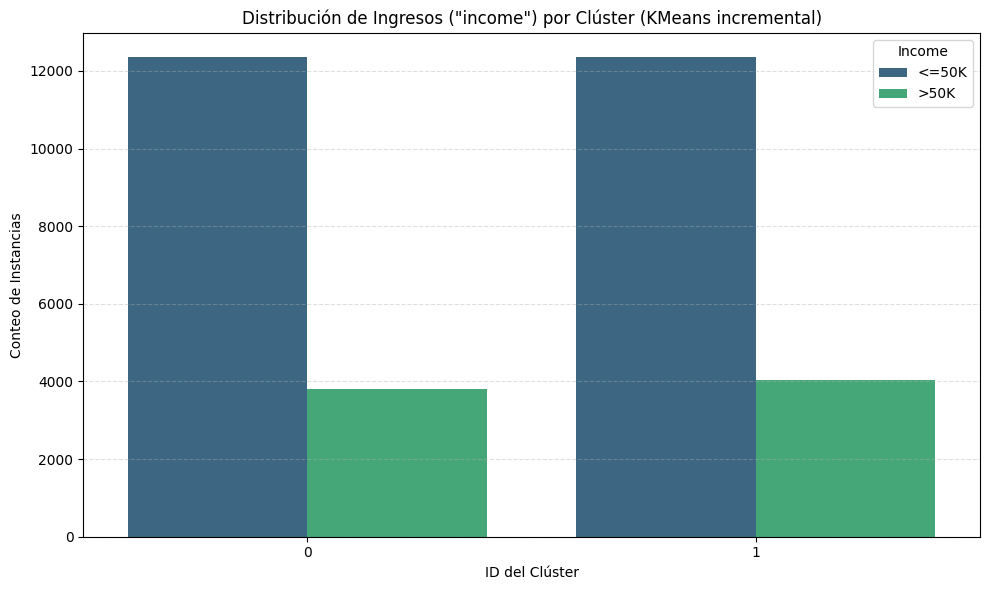

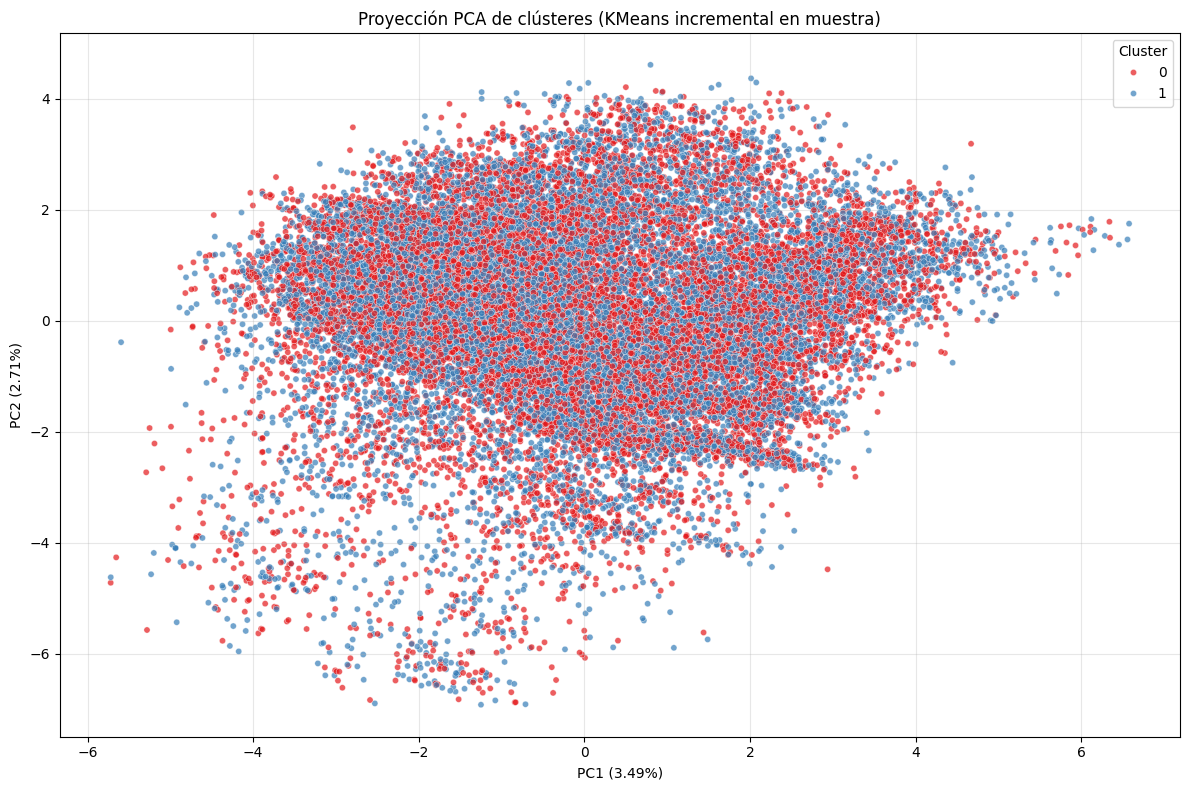

In [9]:
pca = PCA(n_components=2, random_state=random_state)
X_pca = pca.fit_transform(X_batch_scaled)

plot_df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "Cluster": assignments.astype(str),
    "Income": y_income.values
})

# Gráficos
# Distribución de income por cluster
plt.figure(figsize=(10, 6))
sns.countplot(data=plot_df, x='Cluster', hue='Income', palette='viridis')
plt.title('Distribución de Ingresos ("income") por Clúster (KMeans incremental)')
plt.xlabel('ID del Clúster')
plt.ylabel('Conteo de Instancias')
plt.legend(title='Income')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Proyección PCA
plt.figure(figsize=(12, 8))
sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Cluster', palette='Set1', s=20, alpha=0.7)
plt.title('Proyección PCA de clústeres (KMeans incremental en muestra)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.legend(title='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# # Tabla de distribución por cluster
# results_df = pd.DataFrame({
#     'Cluster': assignments,
#     'Income': y_income.values
# })

# print("\nDistribución de instancias por clúster (con proporciones por income):")
# for cid in sorted(np.unique(assignments)):
#     sub = results_df[results_df['Cluster'] == cid]
#     counts = sub['Income'].value_counts(normalize=True).round(3)
#     print(f"\nCluster {cid} (N={len(sub)}):")
#     print(counts.to_string())


Tras varias pruebas con diferentes hiperparametros y probar otros modelos incrementales como DBSTREAM, concluímos que el uso de clustering incremental no es capaz de representar la estructura original de los datos segregada por el valor del income, por ello vemos apropiado comparar con un modelo por lotes y comprobar si este si es capaz. 

### 2.6 Comparativa con clustering por lotes

Debido a la falta de explicabilidad de los clusters generados por el modelo incremental, vemos adecuado comparar el resultado frente a un KMeans por lotes para comprobar si este sí es capaz de dividir el espacio de una forma más explicable (parecido a como lo divide el valor de la etiqueta).

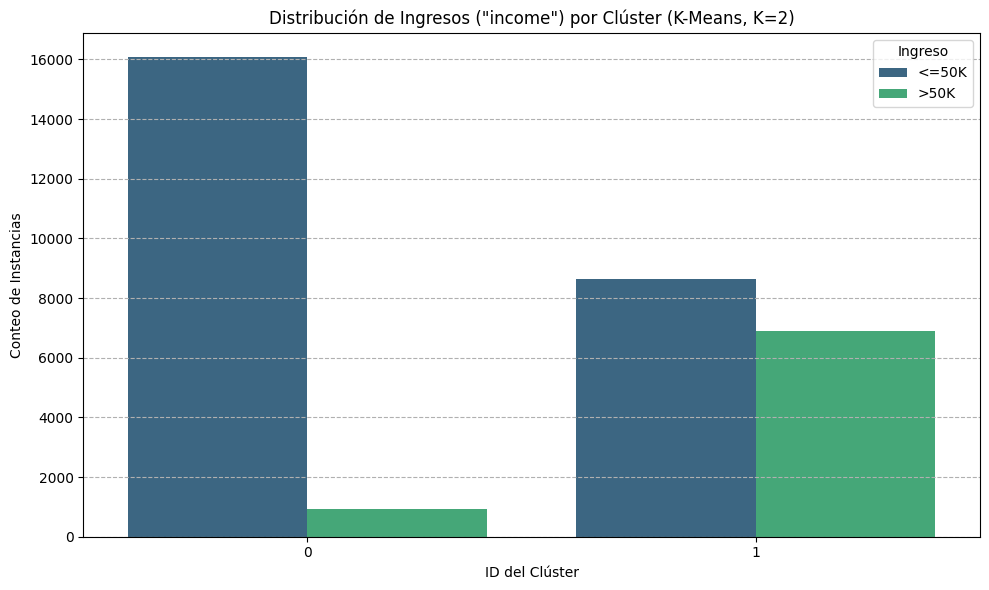

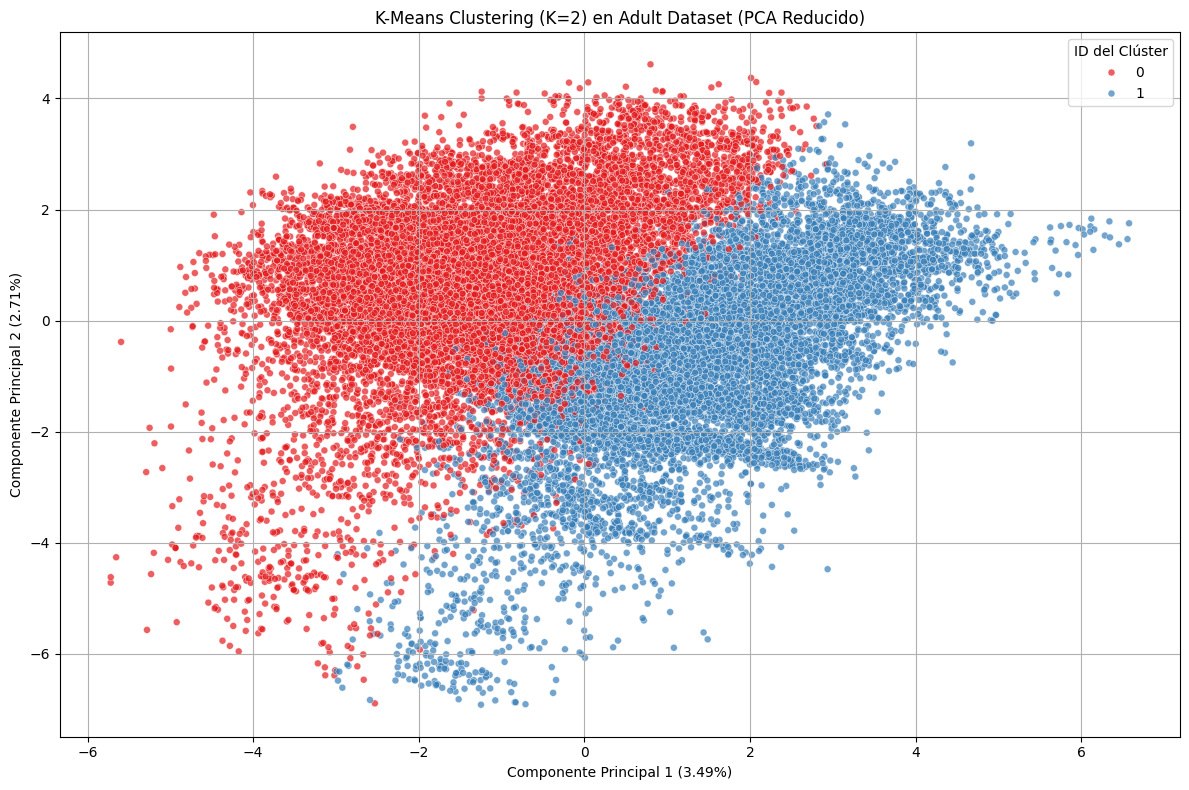

In [10]:
df = pd.read_csv('data/adult.csv')

y_target = df['income']

X = df.drop(columns=['income'])

#preprocesamiento: One-Hot Encoding + Escalado
categorical_cols = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Convertir el array escalado a lista de etiquetas para compatibilidad con la estructura anterior
X_scaled_array = X_scaled_df.values

# Inicializar y entrenar el modelo KMeans con K=2
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10) 
kmeans.fit(X_scaled_array)

# Obtener las etiquetas de cluster
cluster_labels = kmeans.labels_ 

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_array)
X_pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
X_pca_df['Cluster'] = cluster_labels


# Crear un DataFrame único con etiquetas de cluster y la variable objetivo
results_df = pd.DataFrame({
    'Cluster': cluster_labels,
    'Income': y_target
})

plot_df = results_df.copy()
plot_df['Cluster_Str'] = plot_df['Cluster'].astype(str)

plt.figure(figsize=(10, 6))
sns.countplot(
    data=plot_df, 
    x='Cluster_Str', 
    hue='Income', 
    palette='viridis'
)

# Configuración del gráfico de barras
plt.title('Distribución de Ingresos ("income") por Clúster (K-Means, K=2)')
plt.xlabel('ID del Clúster')
plt.ylabel('Conteo de Instancias')
plt.legend(title='Ingreso')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

X_pca_df['Cluster_Str'] = X_pca_df['Cluster'].astype(str)

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PC1',
    y='PC2',
    data=X_pca_df,
    hue='Cluster_Str',
    palette='Set1', # Usamos Set1 para dos colores claros
    s=25,
    alpha=0.7,
    legend='full'
)

plt.title(f'K-Means Clustering (K=2) en Adult Dataset (PCA Reducido)')
plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')

plt.legend(title='ID del Clúster')
plt.grid(True)
plt.tight_layout()
plt.show()

### 2.7 Conclusiones

En esta sección de la práctica se implementó un proceso de clustering incremental utilizando River, con el objetivo de simular un escenario de flujo de datos continuo. El modelo fue capaz de procesar las instancias de manera online y asignar cada ejemplo a un clúster sin necesidad de disponer del conjunto completo, lo cual refleja una ventaja importante para entornos de streaming donde no es posible almacenar todos los datos.

Sin embargo, al analizar los resultados observamos que los clústeres generados no lograron reflejar de manera clara la división natural de la variable objetivo (income). Es decir, el algoritmo incremental no fue capaz de separar los grupos en función de la etiqueta real, lo que sugiere limitaciones en su capacidad de adaptación al tipo de datos y a la complejidad del conjunto utilizado.

Para comparar los resultados, se probó un modelo por lotes entrenado sobre el dataset completo. En este caso los clústeres obtenidos sí lograron aproximarse bastante bien a la división esperada entre los grupos de income, mostrando una clara diferencia frente al modelo online, pues en el cluster 0 apenas hay individuos con un income >50k, lo cual es bueno, pues sabe separar esos datos.

En resumen, el enfoque incremental aporta ventajas en términos de eficiencia y aplicabilidad a datos en flujo, pero presenta desventajas en cuanto a la calidad de los clústeres en comparación con el enfoque tradicional. 


# 3. Regresión

Para el problema de regresión trabajamos con el conjunto de datos California Housing, que contiene información censal sobre características socioeconómicas y de viviendas en distintos distritos de California. Cada observación incluye variables como la mediana de la renta de los hogares, la edad media de las viviendas, el número de habitaciones, el número de ocupantes o la localización geográfica, y está asociada al valor medio de la vivienda en esa zona (en cientos de miles).


Aunque los datos provienen de un archivo estático, en esta práctica planteamos el problema como si las observaciones llegaran de forma secuencial en un flujo de datos. De esta forma, simulamos un escenario realista en el que la información sobre el mercado inmobiliario se actualiza continuamente (por ejemplo, con nuevas tasaciones o registros de compraventas), lo que requiere modelos capaces de adaptarse a cambios de tendencias en el precio de las viviendas, y también a estar preparados para dar predicciones en tiempo real.

# Objetivo
El objetivo principal es implementar un modelo de regresión incremental que, dada una nueva vivienda en tiempo real, prediga el valor medio de las viviendas a partir de las variables disponibles. Para ello, se entrenarán modelos capaces de actualizar sus parámetros de manera progresiva conforme llegan nuevas instancias.

Este enfoque nos permitirá analizar el comportamiento de los modelos de regresión en un entorno dinámico, y ver su posible aplicabilidad en el mundo real:

### 3.1 Carga del csv y vista preliminar

In [18]:
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing(as_frame=True)
df = data.frame    # DataFrame con todas las columnas
print(df.shape)
print(df.head())

(20640, 9)
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  


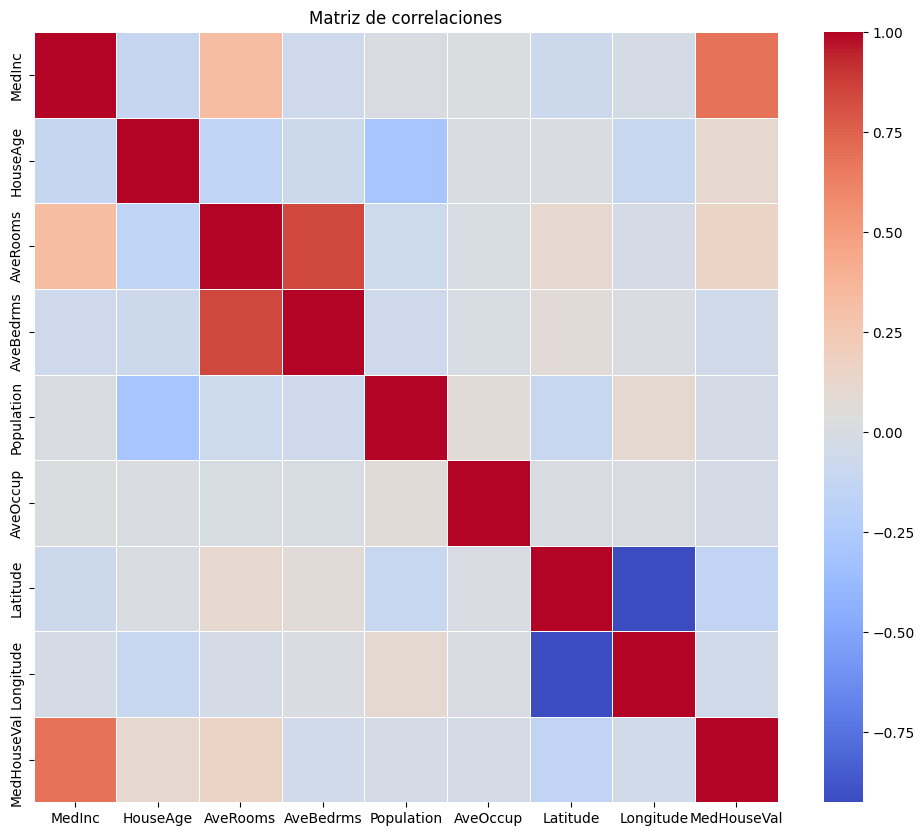

In [19]:
correlation_matrix = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap="coolwarm", linewidths=.5)
plt.title("Matriz de correlaciones")
plt.show()

Vemos que hay algo de correlación, no obstante, al tratarse de flujos de datos, no podemos hacer técnicas de selección de atributos previamente por esto. En todo caso, habría que hacerlo de manera online con los métodos que nos ofrece River.

In [20]:
data_stream = ( #eliminamos la columna objetivo
    (row.drop("MedHouseVal"), row["MedHouseVal"])
    for _, row in df.iterrows() 
)

Métricas de regresión:

In [21]:
R2 = metrics.R2()
MAE = metrics.MAE()

Inicialmente, probamos con modelos lineales simples pero los resultados no fueron nada buenos. Para solucionarlo, incorporamos modelos más complejos como pueden ser los ensembles con arboles de decisión, que son más robustos ante problemas de multicolinealidad. 

Además, haciendo uso de nuestra experiencia y del conocimiento que tenemos del dominio del problema, añadimos un feature selection a la regresión, ya que es normal que en este tipo de problemas haya variables más utiles que otras, y de esta manera eliminamos variables innecesarias y ruído.

En cuanto a la selección de hirperparametros comentar lo siguiente:
- `grace_period` = 40, lo bajamos respecto a los 200 por defecto para favorecer las divisiones en las hojas.
- `model_selector_decay` = 0.6, ya que realmente este dataset no tiene el componente de tempralidad no habría que darle más importancia a las muestras más recientes.
- `n_models` = 4, tomamos 4 árboles para dar robustez sin añadir una complijidad excesiva. 

En cuanto al selector de características elegimos el PoissonInclusion ya que al no tener idea de cuales son los atributos más relevantes a priori, dejaremos que el atributo sea añadido con probabilidad p = 0.4

In [22]:
model = preprocessing.StandardScaler() | ensemble.BaggingRegressor(
    model=tree.HoeffdingAdaptiveTreeRegressor(grace_period=40, model_selector_decay=0.6,seed=42),
    n_models=4,
    seed=42
)
selector = feature_selection.PoissonInclusion(p=0.4, seed=42)

cont = 0
for x,y in data_stream:
    x1 = selector.transform_one(x)
    cont+=1
    y_pred = model.predict_one(x1)
    R2.update(y,y_pred)
    MAE.update(y,y_pred)
    model.learn_one(x1,y)
    if cont % 500 == 0:
        print("M1", R2)
        print("M2", MAE)

print("final", R2)
print("final", MAE)

M1 R2: 0.545666
M2 MAE: 0.425203
M1 R2: 0.592015
M2 MAE: 0.37288
M1 R2: 0.608002
M2 MAE: 0.376482
M1 R2: 0.620254
M2 MAE: 0.397364
M1 R2: 0.666302
M2 MAE: 0.379064
M1 R2: 0.701052
M2 MAE: 0.35042
M1 R2: 0.70415
M2 MAE: 0.342387
M1 R2: 0.725644
M2 MAE: 0.338386
M1 R2: 0.754647
M2 MAE: 0.351918
M1 R2: 0.738301
M2 MAE: 0.367128
M1 R2: 0.770653
M2 MAE: 0.372108
M1 R2: 0.770302
M2 MAE: 0.375465
M1 R2: 0.770073
M2 MAE: 0.369005
M1 R2: 0.772071
M2 MAE: 0.369666
M1 R2: 0.771577
M2 MAE: 0.357295
M1 R2: 0.771551
M2 MAE: 0.347696
M1 R2: 0.764145
M2 MAE: 0.347396
M1 R2: 0.782664
M2 MAE: 0.357461
M1 R2: 0.779775
M2 MAE: 0.366316
M1 R2: 0.776775
M2 MAE: 0.3668
M1 R2: 0.772272
M2 MAE: 0.36882
M1 R2: 0.767646
M2 MAE: 0.377572
M1 R2: 0.766526
M2 MAE: 0.373598
M1 R2: 0.762397
M2 MAE: 0.375573
M1 R2: 0.759086
M2 MAE: 0.375924
M1 R2: 0.762174
M2 MAE: 0.371923
M1 R2: 0.760269
M2 MAE: 0.369377
M1 R2: 0.763435
M2 MAE: 0.365458
M1 R2: 0.761043
M2 MAE: 0.367118
M1 R2: 0.757909
M2 MAE: 0.366279
M1 R2: 0.754069


Finalmente obtenemos un R2 = 0.75 lo que nos indica que el modelo es capaz de explicar un 75% de la varianza de la variable objetivo, lo cual es un resultado aceptable.
En cuanto al MAE, obtenemos un valor de 0.37 unidades en la escala original, esto determina que el erro medio en nuestras predicciones es de esa cantidad.

### 3.2 Comparación frente a un regresor por lotes

Débido a las dudas respecto a las métricas obtenidas vemos apropiado compararlas frente a un modelo regresor por lotes y ver si la diferencia es abultada.

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

data = fetch_california_housing(as_frame=True)
df = data.frame  

X = df.drop(columns=["MedHouseVal"])
y = df["MedHouseVal"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

svr_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", SVR(kernel="rbf", C=10, epsilon=0.1))
])

svr_model.fit(X_train, y_train)

y_pred = svr_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("🔹 Resultados del modelo batch (SVR)")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")


🔹 Resultados del modelo batch (SVR)
MAE:  0.3774
RMSE: 0.5689
R²:   0.7530


Vemos que los resultados son claramente comparables, practicamente iguales, lo que nos dice que nuestro modelo incremental mantiene un buen desempeño a pesar de no conocer a priori todos los datos.

## Conclusiones

Si bien es cierto que, a priori, podríamos pensar que realizar regresión incremental puede ser algo muy complicado, pues es muy sensible a los outliers y a las escalas de los datos, tras probar diferentes modelos incrementales hemos llegado a unos resultados muy comparables con los modelos por lotes.

Tomando un emsemble de árboles HDAT regresores, conseguimos una cierta robustez en las predicciones logrando un MAE relativamente bajo y un buen R2, al mismo tiempo que tenemos todas las ventajas de un modelo incremental como el ahorro de memoria, la capacidad de dar predicciones en tiempo real o la posibilidad de adaptarse a nuevos datos en un flujo real.

# 4. TEXT MINING

Para esta sección del trabajo, el conjunto de datos empleado es sintético, simulando un conjunto real de ofertas de trabajo. En concreto, tendrá 4 columnas, una con el título de la oferta, otra con la descripción del puesto, otra con la categoría del trabajo y otra con la fecha de publicación. Esta última columna, nos permitirá simular que estos datos conforman un flujo real, pues podemos ordenar el dataset por fecha de más antigua a más reciente, haciendo como que los datos van llegando secuencialmente.



## Objetivo

El objetivo es clasificar anuncios de puestos de trabajo en diferentes categorías (tecnologia finanzas deportes salud hosteleria derecho marketing y educacion) a partir del análisis del texto resultante de concatenar el título y la descripción. Para ello, se utilizan técnicas de preprocesamiento de texto (TFIDF) y modelos de clasificación incremental (NB-Multinomial).

### 4.1 Desarrollo

In [2]:
csv = 'data/jobs2.csv'

In [3]:
df = pd.read_csv(csv, parse_dates=["fecha_publicacion"])

In [4]:
df.head()

,titulo,descripcion,categoria,fecha_publicacion
0,Gestor/a de riesgos,Controller buscado para un puesto estable en e...,finanzas,2023-06-07
1,Controller,Contable buscado para un puesto estable en el ...,finanzas,2023-08-13
2,Preparador/a físico/a,Técnico/a de rendimiento buscado para un puest...,deportes,2024-08-14
3,Preparador/a físico/a,Entrenador/a buscado para un puesto estable en...,deportes,2024-11-07
4,Especialista en marketing,Gestor de redes sociales buscado para un puest...,marketing,2024-01-01


In [5]:
df.shape

(12000, 4)

Ordenamos el dataset por fecha para poder simular que los datos han ido llegando progresivamente a través de un flujo de datos:

In [6]:
df = df.sort_values(by="fecha_publicacion", ascending=True)

In [7]:
df = df.reset_index().drop(columns=["index"])

In [8]:
df.head()

,titulo,descripcion,categoria,fecha_publicacion
0,Asesor/a fiscal,Analista financiero/a buscado para un puesto e...,finanzas,2023-01-01
1,Técnico/a de rendimiento,Preparador/a físico/a buscado para un puesto e...,deportes,2023-01-01
2,Técnico/a de rendimiento,Técnico/a de rendimiento buscado para un puest...,deportes,2023-01-01
3,Especialista en marketing,Brand manager buscado para un puesto estable e...,marketing,2023-01-01
4,Procurador/a,Secretario/a legal buscado para un puesto esta...,derecho,2023-01-01


In [9]:
df["categoria"].value_counts()

categoria
tecnologia    2100
finanzas      1900
deportes      1800
salud         1700
hosteleria    1400
derecho       1400
marketing      850
educacion      850
Name: count, dtype: int64

Juntamos todo el texto en una sola columna para ayudar a TFIDF en River

In [10]:
df["text"] = df["titulo"]+". " +df["descripcion"]

Podríamos pensar en borrar columnas innecesarias, pero lo haremos dentro del flujo de datos, ya que realmente en uno real no lo tenemos almacenado en memoria:

In [11]:
#df = df.drop(columns=["descripcion", "titulo", "fecha_publicacion"])

In [12]:
data_stream = ((row.drop("categoria"), row["categoria"]) for _,row in df.iterrows())

Usaremos Naive Bayes multinomial ya que es un modelo que tradicionalmente siempre ha funcionado realmente bien en clasificación de textos. Además, previamente, para el tratamiento de los textos, usaremos TF-IDF porque resalta las palabras clave de un documento al dar más peso a los términos distintivos y restar importancia a los comunes, mejorando así el análisis y comparación de textos.

In [17]:
from river.compose import Pipeline
model = Pipeline(
    ('selector', compose.Discard('descripcion', 'titulo', 'fecha_publicacion')),
    ("tfidf", TFIDF(on="text", lowercase=True, normalize=True)),
    ("nb", MultinomialNB()),
)
metric = metrics.Accuracy()

In [18]:
metric = metrics.Accuracy()
score = evaluate.progressive_val_score(data_stream, model, metric,print_every=500)
print(f"Prequential: Accuracy={score}")

[500] Accuracy: 91.38%
[1,000] Accuracy: 95.70%
[1,500] Accuracy: 97.13%
[2,000] Accuracy: 97.85%
[2,500] Accuracy: 98.28%
[3,000] Accuracy: 98.57%
[3,500] Accuracy: 98.77%
[4,000] Accuracy: 98.92%
[4,500] Accuracy: 99.04%
[5,000] Accuracy: 99.14%
[5,500] Accuracy: 99.22%
[6,000] Accuracy: 99.28%
[6,500] Accuracy: 99.34%
[7,000] Accuracy: 99.39%
[7,500] Accuracy: 99.43%
[8,000] Accuracy: 99.46%
[8,500] Accuracy: 99.49%
[9,000] Accuracy: 99.52%
[9,500] Accuracy: 99.55%
[10,000] Accuracy: 99.57%
[10,500] Accuracy: 99.59%
[11,000] Accuracy: 99.61%
[11,500] Accuracy: 99.63%
[12,000] Accuracy: 99.64%
Prequential: Accuracy=Accuracy: 99.64%


Vemos que los resultados son realmente buenos. Esto era esperable, ya que los conjuntos están bastante diferenciados entre sí, pero este modelo puede servir como un excelente clasificador de ofertas que vengan descategorizadas, para que en tiempo real podamos añadirle esa etiqueta de categoría y añadirla a la sección de anuncios que sea sin necesidad de intervención humana.

Veamos qué pasa si le pasamos palabras de los textos:

In [231]:
unseen = [
    {"text": "entrenamiento"},
    {"text": "sistemas"},
    {"text": "calidad"},
    {"text": "economía"},
    {"text": "red social"},
    {"text": "eventos"},
    {"text": "tutor"}
]

In [232]:
for x in unseen:
    proba = model.predict_proba_one(x)
    print(x["text"], "->", proba)

entrenamiento -> {'finanzas': 0.004986906723608677, 'deportes': 0.9652137034420056, 'marketing': 0.00494117261041397, 'derecho': 0.005036817870717097, 'hosteleria': 0.005013329103459693, 'tecnologia': 0.005040166263189864, 'educacion': 0.004853006603787572, 'salud': 0.004914897382817515}
sistemas -> {'finanzas': 0.010153548411655899, 'deportes': 0.009878248055112232, 'marketing': 0.010060431865042295, 'derecho': 0.010255169572133493, 'hosteleria': 0.010207345470200904, 'tecnologia': 0.9295573999834046, 'educacion': 0.009880922227874726, 'salud': 0.010006934414575681}
calidad -> {'finanzas': 0.005927117037855612, 'deportes': 0.005766410911520062, 'marketing': 0.00587276040827514, 'derecho': 0.005986438221667762, 'hosteleria': 0.9588473521990124, 'tecnologia': 0.0059904179059038455, 'educacion': 0.005767971955433001, 'salud': 0.005841531360331812}
economía -> {'finanzas': 0.9617767787115127, 'deportes': 0.0053518483727142754, 'marketing': 0.005450552122738502, 'derecho': 0.00555605733732

In [233]:
for x in unseen:
    proba = model.predict_proba_one(x)
    print(x["text"], "->", max(proba, key=proba.get))

entrenamiento -> deportes
sistemas -> tecnologia
calidad -> hosteleria
economía -> finanzas
red social -> marketing
eventos -> hosteleria
tutor -> educacion


Hemos visto cómo estas palabras en la categoría a la que pertenecen adecuadamente.

## Conclusiones:

El proceso de minería de texto aplicado a la clasificación de ofertas de trabajo, utilizando la representación de texto mediante TF-IDF y el modelo Naive Bayes Multinomial ha dado resultados muy buenos. La obtención de una precisión del 99 % confirma que la combinación de técnicas de vectorización y algoritmos probabilísticos resulta especialmente efectiva en este dominio, incluso aunque los datos vayan llegando de uno en uno en un flujo.

Como ya comentamos anteriormente, esto podría implementarse en entornos donde se reciben nuevas ofertas de trabajo de forma continua donde algunas vengan descategorizadas y sea nuestro modelo el que le asigne una categoría en tiempo real, evitando así la necesidad de intervención humana.